In [82]:
import pandas as pd

# Dataset obtido em: https://www.kaggle.com/astoeckl/newsen
df = pd.read_csv('retuers_news.csv')

df = df[['Headline','Body']]
df = df.rename(columns={'Body':'body', 'Headline':'headline'})

In [152]:
import nltk
import re

stopwords = nltk.corpus.stopwords.words('english')
stopwords = [s for s in stopwords if re.fullmatch(r"[a-zA-Z]{2,}", s)]

In [83]:
import string
import re

def clean_text(row):
    r = re.compile("[a-zA-Z]{2,}")
    row = row.split()
    row = ' '.join([x.lower() for x in row if re.fullmatch(r, x) and x not in stopwords])
    return row

def clean_df(df):
    df['headline'] = df['headline'].apply(clean_text)
    df['body'] = df['body'].apply(clean_text)
clean_df(df)
df.head()

,headline,body
0,survivors florida school shooting launch gun c...,dozens students parents florida high school te...
1,vw bid delay first diesel emissions trial reje...,virginia state court judge tuesday rejected re...
2,lawyer pleads guilty lying investigators russi...,lawyer one richest men pleaded guilty tuesday ...
3,syria forces enter afrin aid kurds turkey,government forces entered northwestern afrin r...
4,more bombs hit death toll highest since,forces pounded district eastern ghouta distric...


In [84]:
def build_corpus(df):
    corpus = []
    for column in df.columns:
        for row in df[column].iteritems():
            corpus.append(row[1].split())
    return corpus

corpus = build_corpus(df)
print(corpus[42])

['uber', 'ceo', 'sees', 'commercialization', 'flying', 'taxis', 'years']


In [87]:
from gensim.models import word2vec

model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=3000, workers=4)

In [88]:
len(model.wv.vocab)

534

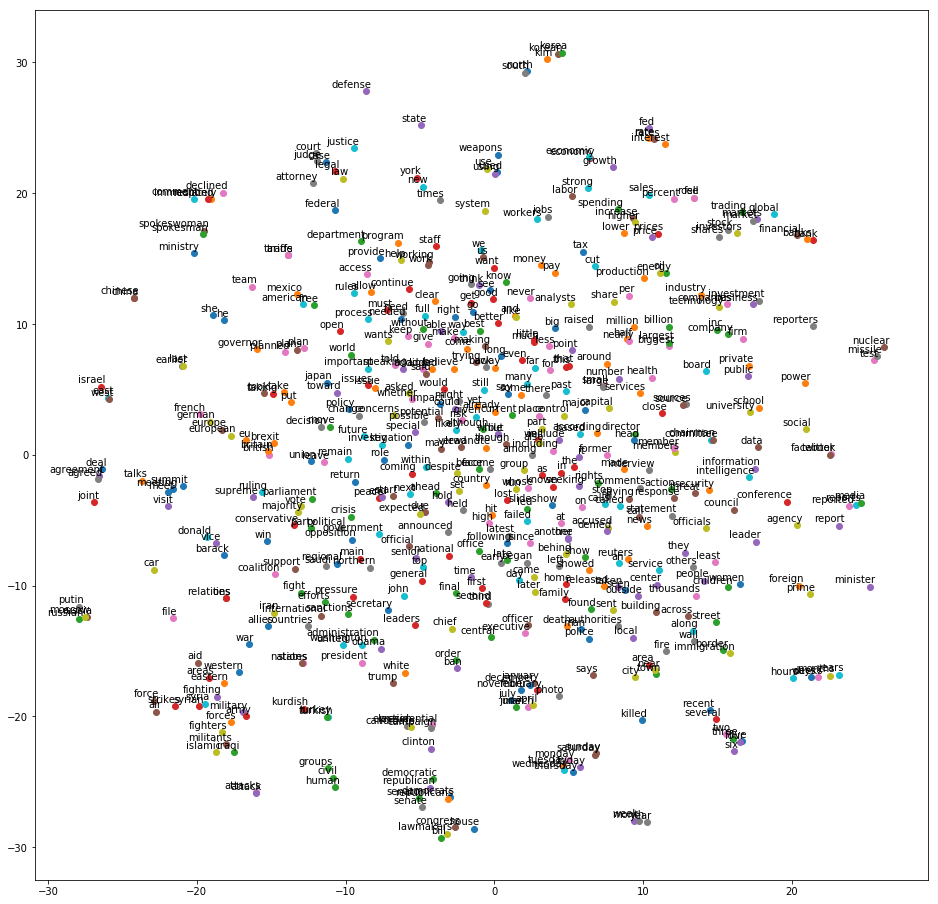

In [105]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(model):
    labels = []
    embeddings = []
    
    for word in model.wv.vocab:
        labels.append(word)
        embeddings.append(model.wv[word])
        
    tsne = TSNE(n_components=2,init='pca', n_iter=2500, random_state=42)
    
    tsne_values = tsne.fit_transform(embeddings)
    
    x = []
    y = []
    for value in tsne_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16,16))

    for i in range(len(tsne_values)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
             xy=(x[i], y[i]),
             xytext=(5, 2),
             textcoords='offset points',
             ha='right',
             va='bottom')
        
    plt.show()
    
    return tsne_values, labels

points, words = plot_tsne(model)
    

In [160]:
word1 = ""
word2 = ""
max_similarity = 0

similarities = []
for w in model.wv.vocab:
    m = model.wv.most_similar(w)
    similarities.append((w, m[0]))
    if m[0][1] > max_similarity:
        max_similarity = m[0][1]
        word1 = w
        word2 = m[0][0]

print('Maximal similarity:', max_similarity, '---> Words:', word1, word2, '\n')

similarities = sorted(similarities, key=lambda x:x[1][1])
for ix, i in enumerate(similarities[::-1]):
    print(ix + 1, i[0], i[1][0], i[1][1])

Maximal similarity: 0.924485445022583 ---> Words: tuesday wednesday 

1 wednesday tuesday 0.924485445022583
2 tuesday wednesday 0.924485445022583
3 friday thursday 0.8938741683959961
4 thursday friday 0.8938741683959961
5 four three 0.8922590017318726
6 three four 0.8922590017318726
7 fell rose 0.889593243598938
8 rose fell 0.889593243598938
9 russia moscow 0.8893830180168152
10 moscow russia 0.8893829584121704
11 five four 0.8759539127349854
12 monday tuesday 0.8689308166503906
13 days weeks 0.8450120687484741
14 weeks days 0.8450118899345398
15 rates rate 0.8422185182571411
16 rate rates 0.8422185182571411
17 second third 0.8419294357299805
18 third second 0.8419294357299805
19 think going 0.8391988277435303
20 going think 0.8391988277435303
21 turkey turkish 0.838268518447876
22 turkish turkey 0.838268518447876
23 month week 0.8371019959449768
24 week month 0.837101936340332
25 chinese china 0.8358221054077148
26 china chinese 0.8358219861984253
27 two three 0.8317424058914185
28 ru

In [110]:
points = list(zip(points.tolist(), words))

In [140]:
import math

def distance(p1, p2):
    return math.sqrt((p1[0][0] - p2[0][0])**2 + (p1[0][1] - p2[0][1])**2)

def strip_closest_pair(strip, d, p1, p2):
    min_ = d
    p1s, p2s = p1, p2
    sorted_strip = list(sorted(strip, key=lambda x:x[0][1]))
    
    for i in range(len(sorted_strip)):
        j = i + 1
        while j < len(sorted_strip) and sorted_strip[j][0][1] - sorted_strip[i][0][1] < min_:
            if distance(sorted_strip[j], sorted_strip[i]) < min_:
                min_ = distance(sorted_strip[i], sorted_strip[j]) 
                p1s, p2s = sorted_strip[i],sorted_strip[j]
            j += 1
    return min_, p1s, p2s
    

def closest_pair_of_points(points, n):
    if len(points) <= 3:
        min_ = 100000000
        for i in range(len(points)):
            j = i + 1
            while j < len(points):
                if distance(points[i], points[j]) < min_:
                    min_ = distance(points[i], points[j])
                    p1, p2 = points[i], points[j]
                j += 1
        return min_, p1, p2
    
    mid = n//2
    mid_point = points[mid]
    
    dl, p1l, p2l = closest_pair_of_points(points[:mid], mid)
    dr, p1r, p2r = closest_pair_of_points(points[mid:], n - mid)
    
    d = min(dl, dr)
    if d == dl:
        p1, p2 = p1l, p2l
    else:
        p1, p2 = p1r, p2r
        
    strip = []

    for i in range(n):
        if abs(points[i][0][0] - mid_point[0][0]) < d:
            strip.append(points[i])
            
    strip_closest_points = strip_closest_pair(strip, d, p1, p2)
    min_ = min(d, strip_closest_points[0])
    
    if min_ == strip_closest_points[0]:
        p1, p2 = strip_closest_points[1], strip_closest_points[2]
    return min_, p1, p2
    
    
        
        
def closest(points):
    sorted_points = list(sorted(points, key=lambda x:x[0][0]))
    n = len(points)
    
    return closest_pair_of_points(sorted_points, n)
    
print(closest(points))




(0.0067381744601980485, ([-24.19834327697754, 11.985877990722656], 'china'), ([-24.19437599182129, 11.991324424743652], 'chinese'))


In [162]:
for i in range(len(points)):
    if points[i][1] == 'wednesday' or points[i][1] == 'tuesday':
        print(points[i])


([4.5773539543151855, -23.795530319213867], 'tuesday')
([4.664673805236816, -24.11204719543457], 'wednesday')
